In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

In [2]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "CPUtimes"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']
N_values = data['N_values']
inneriters = data['inneriters'].item()['IMEX-RB'] + 1

methods = ['BE', 'IMEX-RB']
methods_labels = ['BE', 'IMEX-RB']
methods_marker = ['o', 'x']


/tmp/ipykernel_37298/3856437779.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


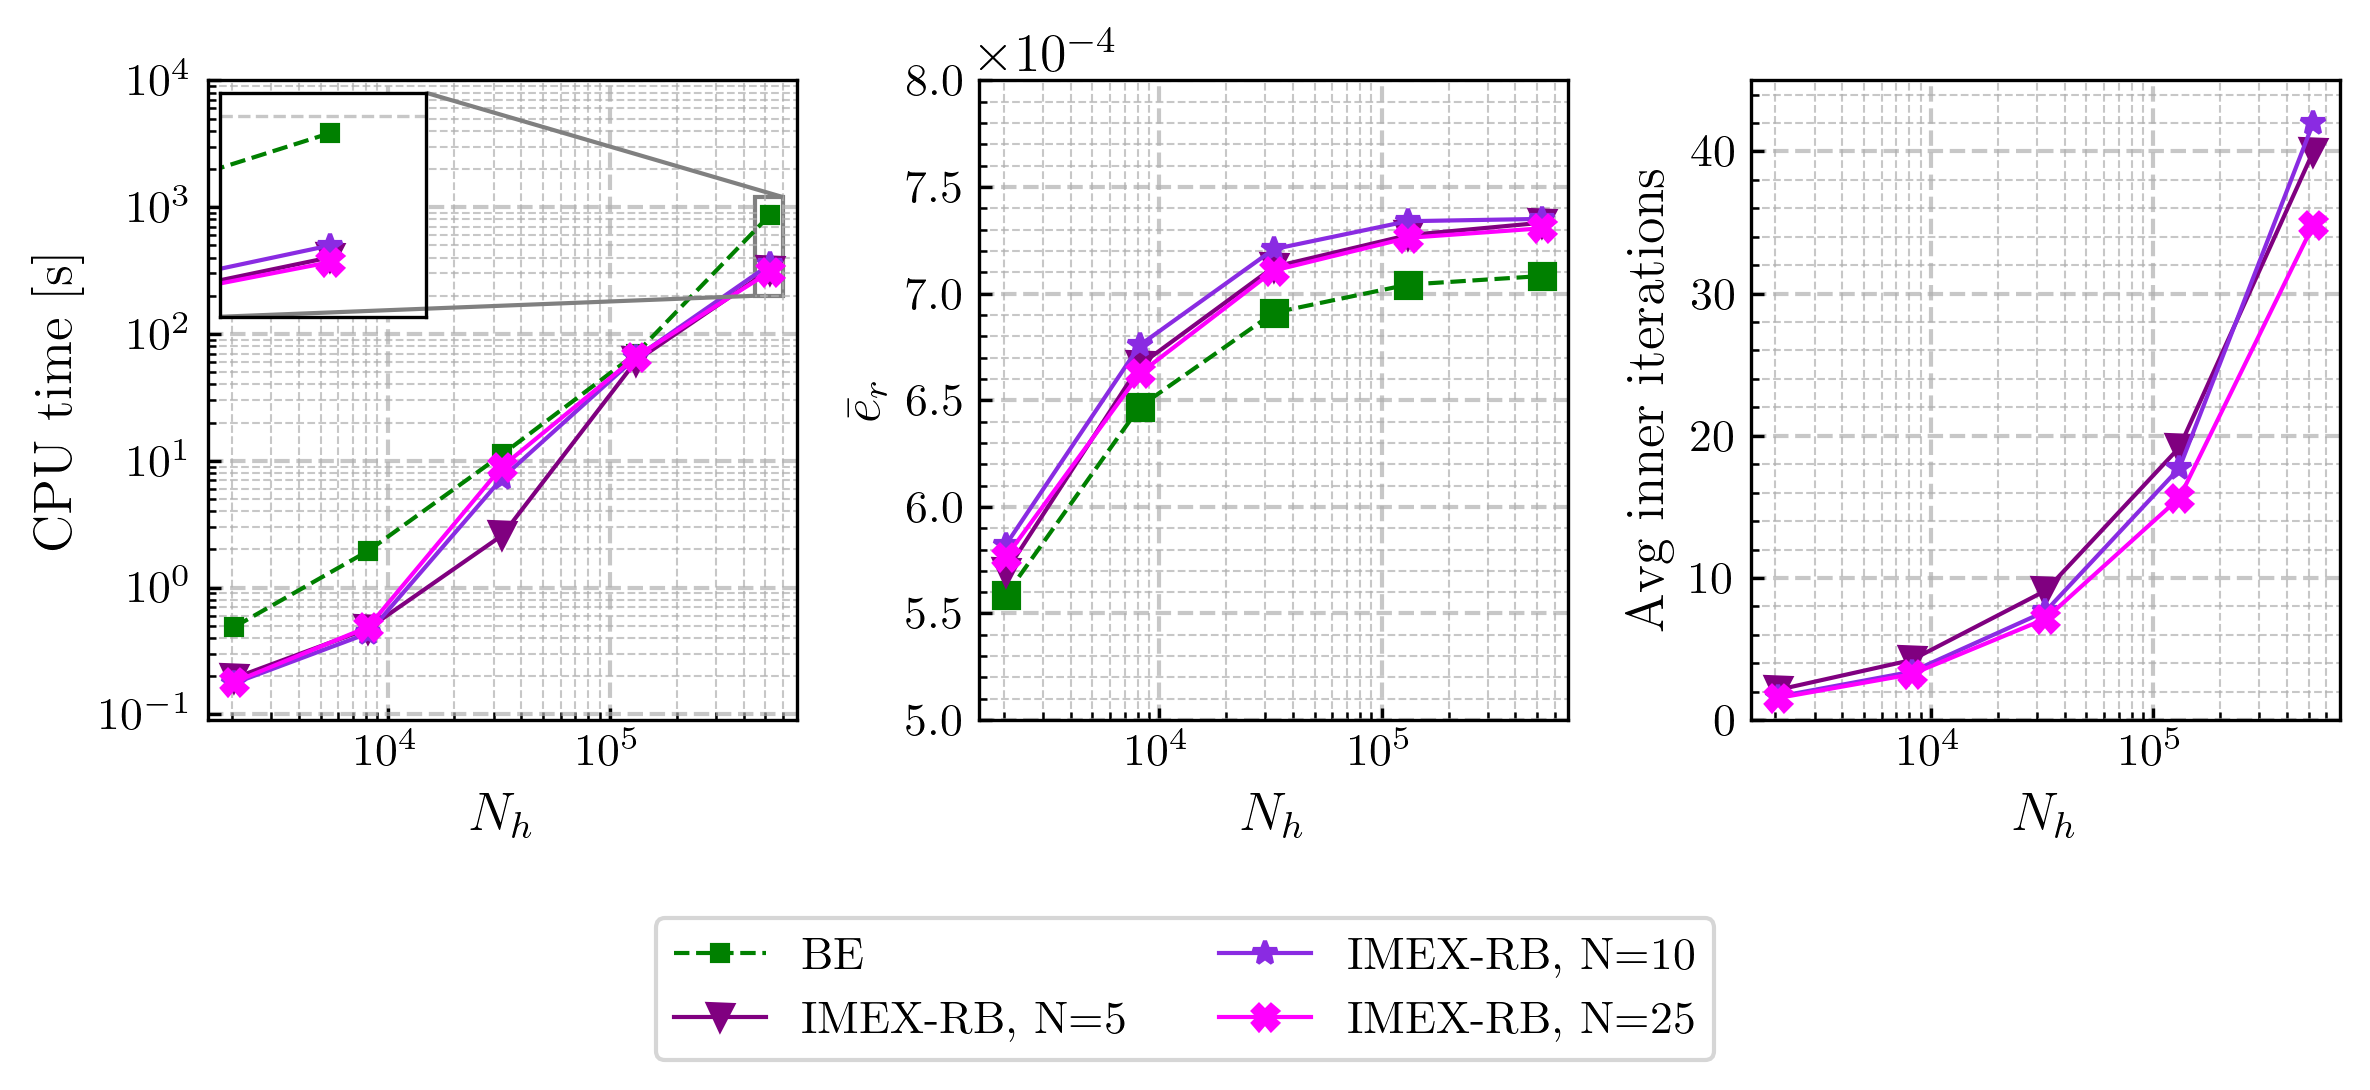

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, LogFormatterSciNotation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

imex_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
colors = ['purple', 'blueviolet', 'magenta', 'hotpink', 'red', 'maroon', 'teal', 'orange']
larger_fontsize = 13
smaller_fontsize = 11

ax1.loglog(Nh_values, times["BE"], linestyle="--",
            marker="s", markersize=4, color="green", label="BE")

for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    ax1.loglog(
        Nh_values,
        times["IMEX-RB"][n_idx],
        marker=marker,
        markersize=6,
        color=colors[n_idx],
        label=f"IMEX-RB, N={N_val}"
    )

ax1.set_xlabel(r"$N_h$", fontsize=larger_fontsize)
ax1.set_ylabel("CPU time [s]", fontsize=larger_fontsize)
ax1.set_ylim((9e-2, 1e4))
ax1.tick_params(axis="both", labelsize=smaller_fontsize)
ax1.grid(which='major', linestyle='--', linewidth=1)
ax1.minorticks_on()
ax1.grid(which='minor', linestyle='--', linewidth=0.5)

inset = inset_axes(
    ax1,
    width="35%",     
    height="35%",  
    loc="upper left",
  #  bbox_to_anchor=(0.19, 0.55, 0.3, 0.6),
  #  bbox_transform=ax1.transAxes
)
# data for inset
inset.loglog(Nh_values, times["BE"], linestyle="--",
             marker="s", markersize=4, color="green")
for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    inset.loglog(
        Nh_values,
        times["IMEX-RB"][n_idx],
        marker=marker,
        markersize=6,
        color=colors[n_idx]
    )
inset.set_xlim(4.5e5, 6e5)
inset.set_ylim(2e2, 1.2e3)
inset.tick_params(axis='both', which='both',
                      bottom=False, top=False,
                      left=False, right=False,
                      labelbottom=False, labelleft=False)
mark_inset(
    ax1, inset,
    loc1=1,    
    loc2=3,   
    fc="none", ec="0.5"
)

# Second subplot: errors
ax2.semilogx(
    Nh_values, errors_l2["BE"],
    marker="s", linestyle="--", markersize=6, color="green"
)


for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    ax2.semilogx(
        Nh_values, errors_l2["IMEX-RB"][n_idx],
        marker=marker, linestyle="-", markersize=6, color=colors[n_idx]
    )

ax2.set_ylim([5e-4, 8e-4])
ax2.set_ylabel(r"$\bar{e}_{r}$", fontsize=larger_fontsize)
ax2.set_xlabel(r"$N_h$", fontsize=larger_fontsize)
ax2.grid(which='major', linestyle='--', linewidth=1)
ax2.minorticks_on()
ax2.grid(which='minor', linestyle='--', linewidth=0.5)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax2.tick_params(axis="both", labelsize=smaller_fontsize)
ax2.yaxis.offsetText.set_fontsize(larger_fontsize)

# subplot: iterations
for n_idx, N_val in enumerate(N_values):
    marker = imex_markers[n_idx % len(imex_markers)]
    avg_inner = np.mean(inneriters[n_idx], axis=1)
    ax3.semilogx(
        Nh_values, avg_inner,
        marker=marker, linestyle="-", markersize=6, color=colors[n_idx],
        label=f"IMEX-RB, $N = {N_val}$"
    )

ax3.set_xlabel(r"$N_h$", fontsize=larger_fontsize)
ax3.set_ylabel("Avg inner iterations", fontsize=larger_fontsize)
ax3.set_ylim((0, 45))
ax3.tick_params(axis="both", which="major", labelsize=smaller_fontsize)
ax3.grid(which='major', linestyle='--', linewidth=1)
ax3.minorticks_on()
ax3.grid(which='minor', linestyle='--', linewidth=0.5)

plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.22),
    fontsize=smaller_fontsize
)

out_file = os.path.join(plots_dir, f"{problem_name}_cputimes_errors_iters.pdf")
plt.savefig(out_file, bbox_inches="tight")
plt.show()
